# Demography Analysis Germany

Exploring the demographic structure per rural district/urban municipality in Germany and analyzing its impact on election returns.

## 1 Overview

In this script, we will try and look for possible relationships between overall demographic structrures as well as gender ratios per different age groups and election results for each district in Germany.

The basis of this analysis are the following datasets

- dataset containing demographic data from 2019 for different age groups and per gender for each german district, taken from [here](https://www-genesis.destatis.de/genesis/online?operation=abruftabelleBearbeiten&levelindex=1&levelid=1626121864721&auswahloperation=abruftabelleAuspraegungAuswaehlen&auswahlverzeichnis=ordnungsstruktur&auswahlziel=werteabruf&code=12411-0018&auswahltext=&werteabruf=starten#abreadcrumb)
- dataset containing election results from [], including numbers on first and second votes per party as well as valid and invalid vodes per german district, taken from [] (weißt du noch von wo du den Datensatz bekommen hast?)
- the geographic boundary data for every district, taken from [opendatalab.de](http://opendatalab.de/projects/geojson-utilities/)

The script is structured as follows. First, the relevant datafiles are importet into this session and pre-processed. A mapping table is created for the correct assignment between the different data fields as well as the geographic boundary data. Next, we create different metrics for visualization purposes. We analyse distributions and the impact of differen metrics on election results via simple correlations. In addition, data tables are created for the demographic structures and the resulting plots are saved. Then, we write the function for interactive maps based on these distributions and the previously computed metrics. 

Lets start by importing the necessary packages and setting directories for the input data and the resulting files.

>**NOTE:** In the follow up script, we try to train a simple neural network (multi layer perceptron, aka MLP) to predict election results, i.e. on the one hand the share of election results for a specific party, and on the other hand distributions of voting results (this is done via a sample of districts, based on features that were derived from this script). 

In [1]:
import pandas as pd
import numpy as np
import geojson
import matplotlib.pyplot as plt
from tqdm import notebook

from scipy.stats import pearsonr
from itertools import product

from shapely.geometry import Point,shape #filter geo coordinates based on polygonal areas
import branca.colormap as cmp #define a color gradient manually 
from folium import IFrame
import base64
import folium #manipulate data and visualize on a Leaflet map 
from folium.map import *
from folium.plugins import MeasureControl
from folium.features import DivIcon

plt.style.use('dark_background')

data_dir = './data/'
result_dir = './results/'

## 2 Pre-Processing

First, we want to import the csv files and bring them into the right format. The following procedure is done for the demographic datatable and the one for election results (the sequence is basically the same).

We fetch the index which will consist of the name for each area and the columns that represent the different age groups per sex. However, lets implement the columns as multi-columns, the first level representing the sex (male/female) and the second level the age groups. 

In [2]:
df_demogr = pd.read_csv(data_dir + '12411-0018.csv',sep=';',encoding='latin')

index = df_demogr.loc[5:480,'Unnamed: 2']
cols = df_demogr.loc[3:4,'Unnamed: 3':]
df_demogr = df_demogr.loc[5:480,'Unnamed: 3':]

In [3]:
#create multi columns from tuples
multicol = []
for cc in range(cols.shape[1]):
    multicol.append((cols.loc[3,:][cc],cols.loc[4,:][cc]))

In [4]:
#set the multi columns and index
df_demogr.columns = pd.MultiIndex.from_tuples(multicol)
df_demogr.index = index
df_demogr.index.name = 'city'

Next, replace empty cells with NaN's, convert the dataset to float and drop the NaN's afterwards  

In [5]:
df_demogr.replace('-',np.nan,inplace=True)
df_demogr = df_demogr.astype(float)
df_demogr.dropna(how='any',inplace=True)

We created the dataframe `df_demogr` for the demographic structures. However, the ranges of age groups differ, so we want to make them uniform, consisting of intervalls of 15 years. Lets create the new dataframe `df_demogr_grp`.

In [6]:
#create new age groups that have same range
ageGrps = ['0-14','15-29','30-44','45-59','60-74','75+']
#create new multi column
multicol = []
for ag in ageGrps:
    multicol.append(('männlich',ag))
    multicol.append(('weiblich',ag))

multicol.sort()

#initialize empty dataframe with right dimensions, index and columns
df_demogr_grp = pd.DataFrame(np.zeros((len(df_demogr.index),len(multicol))),index=df_demogr.index)
df_demogr_grp.columns = pd.MultiIndex.from_tuples(multicol)

#fill in the age groups per sex by adding up the respective columns from df_demogr
df_demogr_grp['männlich'].loc[:,'0-14'] = df_demogr['männlich'].loc[:,'unter 3 Jahre'] + \
                                    df_demogr['männlich'].loc[:,'3 bis unter 6 Jahre'] + \
                                    df_demogr['männlich'].loc[:,'6 bis unter 10 Jahre'] + \
                                    df_demogr['männlich'].loc[:,'10 bis unter 15 Jahre']
df_demogr_grp['männlich'].loc[:,'15-29'] = df_demogr['männlich'].loc[:,'15 bis unter 18 Jahre'] + \
                                    df_demogr['männlich'].loc[:,'18 bis unter 20 Jahre'] + \
                                    df_demogr['männlich'].loc[:,'20 bis unter 25 Jahre'] + \
                                    df_demogr['männlich'].loc[:,'25 bis unter 30 Jahre']
df_demogr_grp['männlich'].loc[:,'30-44'] = df_demogr['männlich'].loc[:,'30 bis unter 35 Jahre'] + \
                                    df_demogr['männlich'].loc[:,'35 bis unter 40 Jahre'] + \
                                    df_demogr['männlich'].loc[:,'40 bis unter 45 Jahre']
df_demogr_grp['männlich'].loc[:,'45-59'] = df_demogr['männlich'].loc[:,'45 bis unter 50 Jahre'] + \
                                    df_demogr['männlich'].loc[:,'50 bis unter 55 Jahre'] + \
                                    df_demogr['männlich'].loc[:,'55 bis unter 60 Jahre']
df_demogr_grp['männlich'].loc[:,'60-74'] = df_demogr['männlich'].loc[:,'60 bis unter 65 Jahre'] + \
                                    df_demogr['männlich'].loc[:,'65 bis unter 75 Jahre']
df_demogr_grp['männlich'].loc[:,'75+'] = df_demogr['männlich'].loc[:,'75 Jahre und mehr']

df_demogr_grp['weiblich'].loc[:,'0-14'] = df_demogr['weiblich'].loc[:,'unter 3 Jahre'] + \
                                    df_demogr['weiblich'].loc[:,'3 bis unter 6 Jahre'] + \
                                    df_demogr['weiblich'].loc[:,'6 bis unter 10 Jahre'] + \
                                    df_demogr['weiblich'].loc[:,'10 bis unter 15 Jahre']
df_demogr_grp['weiblich'].loc[:,'15-29'] = df_demogr['weiblich'].loc[:,'15 bis unter 18 Jahre'] + \
                                    df_demogr['weiblich'].loc[:,'18 bis unter 20 Jahre'] + \
                                    df_demogr['weiblich'].loc[:,'20 bis unter 25 Jahre'] + \
                                    df_demogr['weiblich'].loc[:,'25 bis unter 30 Jahre']
df_demogr_grp['weiblich'].loc[:,'30-44'] = df_demogr['weiblich'].loc[:,'30 bis unter 35 Jahre'] + \
                                    df_demogr['weiblich'].loc[:,'35 bis unter 40 Jahre'] + \
                                    df_demogr['weiblich'].loc[:,'40 bis unter 45 Jahre']
df_demogr_grp['weiblich'].loc[:,'45-59'] = df_demogr['weiblich'].loc[:,'45 bis unter 50 Jahre'] + \
                                    df_demogr['weiblich'].loc[:,'50 bis unter 55 Jahre'] + \
                                    df_demogr['weiblich'].loc[:,'55 bis unter 60 Jahre']
df_demogr_grp['weiblich'].loc[:,'60-74'] = df_demogr['weiblich'].loc[:,'60 bis unter 65 Jahre'] + \
                                    df_demogr['weiblich'].loc[:,'65 bis unter 75 Jahre']
df_demogr_grp['weiblich'].loc[:,'75+'] = df_demogr['weiblich'].loc[:,'75 Jahre und mehr']

C:\Users\polis\anaconda3\lib\site-packages\pandas\core\indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [7]:
#lets look at the new dataframe
df_demogr_grp.head()

männlich                                      \
                                 0-14    15-29    30-44    45-59    60-74   
city                                                                        
Flensburg, kreisfreie Stadt    6154.0  10764.0   8539.0   9011.0   6518.0   
Kiel, kreisfreie Stadt        15711.0  28112.0  25266.0  24483.0  16753.0   
Lübeck, kreisfreie Stadt      13992.0  19362.0  19858.0  23201.0  16667.0   
Neumünster, kreisfreie Stadt   5620.0   7434.0   7417.0   8877.0   6395.0   
Dithmarschen, Landkreis        8650.0  11056.0  10409.0  15601.0  12666.0   

                                      weiblich                             \
                                  75+     0-14    15-29    30-44    45-59   
city                                                                        
Flensburg, kreisfreie Stadt    3918.0   5818.0  10297.0   7289.0   8919.0   
Kiel, kreisfreie Stadt         9873.0  15046.0  28584.0  24820.0  24651.0   
Lübeck, kreisfreie Stadt      10952.0  13245.0  18935.0  19590.0  24210.0   
Neumünster, kreisfreie Stadt   3980.0   5232.0   6651.0   6917.0   8785.0   
Dithmarschen, Landkreis        7336.0   8314.0  10033.0  10173.0  15862.0   

                                                
                                60-74      75+  
city                                            
Flensburg, kreisfreie Stadt    7290.0   5647.0  
Kiel, kreisfreie Stadt        18715.0  14780.0  
Lübeck, kreisfreie Stadt      19555.0  16963.0  
Neumünster, kreisfreie Stadt   6984.0   5904.0  
Dithmarschen, Landkreis       13258.0   9835.0

As a first sanity check, lets have a look at the ratio of males to females over all age groups and for each district 

In [8]:
#create a pandas series for the ratio
sex_ratio = pd.Series(index = df_demogr.index, dtype=float)

for city in notebook.tqdm(sex_ratio.index):
    #check if an age group is not represented to avoid dividing by zero  
    if df_demogr['männlich'].loc[city,:].isnull().values.any() | df_demogr['weiblich'].loc[city,:].isnull().values.any():
        sex_ratio[city] = np.nan
        
    else:
        sex_ratio[city] = df_demogr['männlich'].loc[city,:].sum() / df_demogr['weiblich'].loc[city,:].sum()

  0%|          | 0/401 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Male to Female ratio')

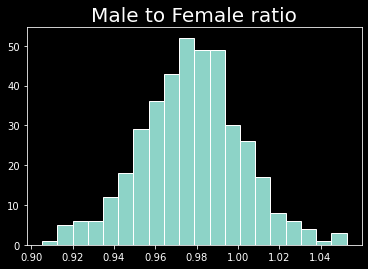

In [9]:
plt.hist(sex_ratio,bins=20,edgecolor='white')
plt.title('Male to Female ratio',fontsize=20)

On average, both sexes are equally represented with a slight bias towards males. Note that this distribution is taken over all age groups and that the ratio per group might differ!

Next, we import the election data and repeat the previous procedure.

In [10]:
df_election = pd.read_csv(data_dir + 'btw2017kreis.csv',sep=';',encoding='latin')

#get the data, index and columns as before
index = df_election.loc[5:407,'Unnamed: 2']
cols = df_election.loc[3:4,'Unnamed: 3':]
df_election = df_election.loc[5:407,'Unnamed: 3':]

#create multicolumns
multicol = []
for cc in range(cols.shape[1]):
    multicol.append((cols.loc[3,:][cc],cols.loc[4,:][cc]))
    
df_election.columns = pd.MultiIndex.from_tuples(multicol)
df_election.index = index
df_election.index.name = 'city'  

#since this data splits the capitol into West- and East-Berlin, we create a nex entry for the whole of Berlin
df_election.loc['Berlin, kreisfreie Stadt',:] = df_election.loc['Berlin-West, Stadt',:] + \
                                                df_election.loc['Berlin-Ost, Stadt',:]
#convert to float for savety
df_election = df_election.astype(float)
df_election_names = pd.Series(df_election.index)

We saved the names of each city/district for the election data in the series object `df_election_names`. The reason for this will become apparent in a moment. 

We have to deal with different naming conventions in the two datasets. We want to make them consistent, as we are interested at looking at relations between age groups/gender ratios and election results. Note that in the namings, each city is followed by a surfix, indicating if its a Landkreis or kreisfreie Stadt. 

There are many equivalent namings for Landkreis and kreisfreie Stadt, so lets look at all the surfixes in `df_election_names`.

In [11]:
tt = []
for el in df_election_names:
    temp = el.split(', ')
    if len(temp)==2:
        tt.append(temp[1])
        
tt = pd.Series(tt)
tt.unique()

array(['Stadt', 'Landeshauptstadt', 'Hansestadt', 'Freie und Hansestadt',
       'Klingenstadt', 'Stadt der FernUniversität', 'Wissenschaftsstadt',
       'documenta-Stadt', 'Universitätsstadt', 'kreisfreie Stadt'],
      dtype=object)

In the election data, only cities (kreisfreie Städte) have a surfix and they are all equivalent to kreisfreie Stadt. Therefore, lets change them all to kreisfreie Stadt and add the surfix Landkreis to the remaining ones. The new series of names is denoted by `df_election_names_f`.

In [12]:
#the above analysis shows, that all surfixes are equivalent to 'kreisfreie Stadt' 
df_election_names_f = []

for elec in df_election_names:
    #split each entry by ', ' and create a list. If the city has a surfix, the list will contain two entries
    temp = elec.split(', ')
    #this is the only special case for Rostock
    if temp[0] == 'Landkreis Rostock':
        df_election_names_f.append('Rostock, Landkreis')
    #if the list has only entry, add Lankreis, otherwhise overwrite it with kreisfreie Stadt    
    elif len(temp)==1:
        df_election_names_f.append(temp[0] + ', Landkreis')
    elif len(temp)==2:
        df_election_names_f.append(temp[0] + ', kreisfreie Stadt')
     
df_election_names_f = pd.Series(df_election_names_f)
df_election.index = df_election_names_f

Now, we want to create a mapping table between the two datasets. The idea is to create a dataframe, where one column equals the naming from the demographic dataset and the other equals the naming from the election dataset. Again, we adjust the names from `df_demogr` by adding the surfix Landkreis if needed. Lets call this series object `df_names`.

In [13]:
df_names = pd.Series(df_demogr.index)

#same procedure as before
for idx in df_names.index:
    temp = df_names[idx].split(', ')
    if len(temp) == 1:
        df_names[idx] += ', Landkreis'

Lets overwrite the indices of our demography data tables (the original `df_demogr` and the ones with new age groups `df_demogr_grp`) with the new ones.

In [14]:
df_demogr.index = df_names
df_demogr_grp.index = df_names

We have to analyse the namings in `df_names` (demography data) and `df_election_nams_f` (election data).

In [15]:
print('Length of df_names {}\nLength of df_election_names_f {}'.format(len(df_names),len(df_election_names_f)))

Length of df_names 401
Length of df_election_names_f 404


As we can see, the two datasets don't have the same length. For example, the election dataset distinguishes between East- and West-Berlin and has therefore additional rows.

Now, lets do a consistency check and find out for which entries the names differ. This is easily done via the `isin` command for pandas series objects.

In [16]:
print('Numbers of elements from df_election_names missing in df_names {}'.format(
    len(df_names[~df_names.isin(df_election_names_f)])))
print('Numbers of elements from df_names missing in df_election_names_f {}'.format(
    len(df_election_names_f[~df_election_names_f.isin(df_names)])))

Numbers of elements from df_election_names missing in df_names 9
Numbers of elements from df_names missing in df_election_names_f 12


Lets list all the cities from `df_names` that are **not** in `df_election_names_f` 

In [17]:
df_election_names_f[~df_election_names_f.isin(df_names)]

237                      Mühldorf a.Inn, Landkreis
240                Pfaffenhofen a.d.Ilm, Landkreis
259              Weiden i.d.OPf., kreisfreie Stadt
262                   Neumarkt i.d.OPf., Landkreis
263               Neustadt a.d.Waldnaab, Landkreis
279          Wunsiedel i.Fichtelgebirge, Landkreis
289    Neustadt a.d.Aisch-Bad Windsheim, Landkreis
310                 Dillingen a.d.Donau, Landkreis
323                          St. Wendel, Landkreis
324                   Berlin-Ost, kreisfreie Stadt
325                  Berlin-West, kreisfreie Stadt
402                        Bundesgebiet, Landkreis
dtype: object

Unmark the following line of code to see how the respective city is named in `df_names`.

In [18]:
#use to find out names for following mapping table
#df_names[df_names.apply(lambda x: 'Mühldorf' in x)]

With this, let us create the mapping table. We start by creating a series object from `df_names` where its index equals its entries. We do this, so that we overwrite only those names, that are inconsistent between the two datasets, as done in the following. 

In [19]:
mapping_names = df_names.copy()
mapping_names.index = df_names.copy()
mapping_names.index.name = 'df'

#overwrite the entries that differ between the two datasets
mapping_names['Mühldorf am Inn, Landkreis'] = 'Mühldorf a.Inn, Landkreis'
mapping_names['Pfaffenhofen an der Ilm, Landkreis'] = 'Pfaffenhofen a.d.Ilm, Landkreis'
mapping_names['Weiden in der Oberpfalz, kreisfreie Stadt'] = 'Weiden i.d.OPf., kreisfreie Stadt'
mapping_names['Neumarkt in der Oberpfalz, Landkreis'] = 'Neumarkt i.d.OPf., Landkreis'
mapping_names['Neustadt an der Waldnaab, Landkreis'] = 'Neustadt a.d.Waldnaab, Landkreis'
mapping_names['Wunsiedel im Fichtelgebirge, Landkreis'] = 'Wunsiedel i.Fichtelgebirge, Landkreis'
mapping_names['Neustadt an der Aisch-Bad Windsheim, Landkreis'] = 'Neustadt a.d.Aisch-Bad Windsheim, Landkreis'
mapping_names['Dillingen an der Donau, Landkreis'] = 'Dillingen a.d.Donau, Landkreis'
mapping_names['Sankt Wendel, Landkreis'] = 'St. Wendel, Landkreis'
#mapping_names['Berlin, kreisfreie Stadt'] = 'Berlin-West, kreisfreie Stadt' #only consider Berlin-West for now! 

Next take care of the fact, that the election dataset has more entries. Then, convert the series into a dataframe, where the first column `df` equals the names from the demographic dataset and where the second column `df_election` equals the names from the election results. The index of this new mapping table `mapping_filtered_names` is set to a numeric index, raning from 0 to 400. This will be important in the next step. 

In [20]:
#filter for the nmes that are in both datasets 
mapping_filtered_names = mapping_names[mapping_names.isin(df_election_names_f)]
mapping_filtered_names.index = mapping_names[mapping_names.isin(df_election_names_f)].index

mapping_filtered_names = mapping_filtered_names.to_frame()
mapping_filtered_names.reset_index(inplace=True)
mapping_filtered_names.columns = ['df','df_election']

We succeeded in making our data consistent. Now we have to do the same for our geographical data.

We start by importing the data, which is in the geojson data format. I had difficulties overwriting and transforming this data type, since I could only create shallow copies of it. To bypass this issue, I imported the same geodata three different times, one time for each step in the following processing procedure. 

In [21]:
with open(data_dir+'landkreise_simplify20.geojson',encoding='utf-8') as f:
    gj_lk = geojson.load(f)
with open(data_dir+'landkreise_simplify20.geojson',encoding='utf-8') as f:
    gj_lk_f1 = geojson.load(f) 
with open(data_dir+'landkreise_simplify20.geojson',encoding='utf-8') as f:
    gj_lk_f2 = geojson.load(f)          

Analyzing the data, we see that we only need the first 401 elements (107 kreisfreie Städte + 294 Kreise)

>**NOTE:** make yourself comfortable with the dataformat in order to understand the following steps.

The relevant geo data is saved in the *feautures* attribute. Due to the shallow-copy-problem, I deleted the *features* attribbute in `gj_lk_f1` and replaced it up to the 401st entry of `gj_lk`.

In [22]:
#only take the first 401 elements in either feature key (107 kreisfreie Städte + 294 Kreise)
gj_lk_f1['features'] = []
for idx in range(401):
    gj_lk_f1['features'].append(gj_lk['features'][idx])

Now, we have to adjust the names again. You can find the city names in the geodata under *properties*$\rightarrow$*GEN* and the city type (for example: kreisfreie Stadt) under *properties*$\rightarrow$*BEZ*. *properties* is an attribute under each entry in the list contained in *features*.

We do the same procedure as before. If the city type is either Kreisfreie Stadt or Stadtkreis, we overwrite it with kreisfreie Stadt (notice the lower letter). If the city type is Kreis, we overwrite it with Landkreis. The new names are saved under the new series object `gj_names` as well as a new entry in `gj_lk_f1` and `gj_lk_f2`.  

In [23]:
gj_names = []

for idx in range(len(gj_lk_f1['features'])):
    gen = gj_lk_f1['features'][idx]['properties']['GEN']
    bez = gj_lk_f1['features'][idx]['properties']['BEZ']
    if (bez == 'Kreisfreie Stadt') | (bez == 'Stadtkreis'):
        bez = 'kreisfreie Stadt' 
    elif bez == 'Kreis':
        bez = 'Landkreis'
        
    city_name = gen + ', ' + bez
    
    gj_names.append(city_name)    
    gj_lk_f1['features'][idx]['properties']['name'] = city_name
    gj_lk_f2['features'][idx]['properties']['name'] = city_name
    
gj_names = pd.Series(gj_names)    

In [24]:
print('Length of mapping {}\nLength of gj_names {}'.format(mapping_filtered_names.shape[0],len(gj_names)))

Length of mapping 401
Length of gj_names 401


As before, we do the consistency check between the geodata and the demography data by comparing `gj_names` with `mapping_filtered_names`.

In [25]:
print('Numbers of elements from gj_names missing in mapping (df) {}'.format(
    len(mapping_filtered_names['df'][~mapping_filtered_names['df'].isin(gj_names)])))
print('Numbers of elements from mapping (df) missing in gj_names {}'.format(
    len(gj_names[~gj_names.isin(mapping_filtered_names['df'])])))

Numbers of elements from gj_names missing in mapping (df) 10
Numbers of elements from mapping (df) missing in gj_names 10


We filter out the names that are different and proceed as before.

In [26]:
mapping_filtered_names['df'][~mapping_filtered_names['df'].isin(gj_names)]

46            Oldenburg (Oldenburg), kreisfreie Stadt
237                        Mühldorf am Inn, Landkreis
240                Pfaffenhofen an der Ilm, Landkreis
259         Weiden in der Oberpfalz, kreisfreie Stadt
262              Neumarkt in der Oberpfalz, Landkreis
263               Neustadt an der Waldnaab, Landkreis
279            Wunsiedel im Fichtelgebirge, Landkreis
289    Neustadt an der Aisch-Bad Windsheim, Landkreis
310                 Dillingen an der Donau, Landkreis
323                           Sankt Wendel, Landkreis
Name: df, dtype: object

In [27]:
#gj_names[gj_names.apply(lambda x: 'Wendel' in x)]

We already have our mapping table, so lets add a new column `gj` by copying the column `df`. Then, we adjust the names that differ.   

In [28]:
mapping_filtered_names['gj'] = mapping_filtered_names['df'].copy(deep=True)

mapping_filtered_names.loc[
    mapping_filtered_names['df']=='Oldenburg (Oldenburg), kreisfreie Stadt','gj'] = 'Oldenburg (Oldb), kreisfreie Stadt'
mapping_filtered_names.loc[
    mapping_filtered_names['df']=='Mühldorf am Inn, Landkreis','gj'] = 'Mühldorf a. Inn, Landkreis'
mapping_filtered_names.loc[
    mapping_filtered_names['df']=='Pfaffenhofen an der Ilm, Landkreis','gj'] = 'Pfaffenhofen a.d. Ilm, Landkreis'
mapping_filtered_names.loc[
    mapping_filtered_names['df']=='Weiden in der Oberpfalz, kreisfreie Stadt','gj'] = 'Weiden i.d. OPf., kreisfreie Stadt'
mapping_filtered_names.loc[
    mapping_filtered_names['df']=='Neumarkt in der Oberpfalz, Landkreis','gj'] = 'Neumarkt i.d. OPf., Landkreis'
mapping_filtered_names.loc[
    mapping_filtered_names['df']=='Neustadt an der Waldnaab, Landkreis','gj'] = 'Neustadt a.d. Waldnaab, Landkreis'
mapping_filtered_names.loc[
    mapping_filtered_names['df']=='Wunsiedel im Fichtelgebirge, Landkreis','gj'] = 'Wunsiedel i. Fichtelgebirge, Landkreis'
mapping_filtered_names.loc[
    mapping_filtered_names['df']=='Neustadt an der Aisch-Bad Windsheim, Landkreis','gj'] = 'Neustadt a.d. Aisch-Bad Windsheim, Landkreis'
mapping_filtered_names.loc[
    mapping_filtered_names['df']=='Dillingen an der Donau, Landkreis','gj'] = 'Dillingen a.d. Donau, Landkreis'
mapping_filtered_names.loc[
    mapping_filtered_names['df']=='Sankt Wendel, Landkreis','gj'] = 'St. Wendel, Landkreis'

The last step is to rearange the order of the cities in the geojson data, according to the order in the mapping table. This is the reason that we added the numerical index to `mapping_filtered_names`. Again, we can't just easily delete and replace entries from the geojson object. Thus, we delete the entries from the *feature* attribute in `gj_lk_f2` and add in the *feature* attribute entries from `gj_lk_f1` **in the right order** (with respect to the index from `mapping_filtered_names`). 

For plotting purposes later on, we have to add a new key called `id` to each feature in `gj_lk_f2` (note that `gj_lk` and `gj_lk_f1` are not needed anymore after the next code block).

In [29]:
gj_lk_f2['features'] = []

#go through each city in gj_names
for idx in range(len(gj_names)):
    
    #we check if the name is inside mapping_filtered_names.
    condition = mapping_filtered_names.loc[mapping_filtered_names['gj'] == gj_names[idx],:]
    
    #if the statement returns a non-empty object, we copy the feature entry from gj_lk_f1
    #and add the index from mapping_filtered_names as a new id-key
    if not condition.empty:
        temp = gj_lk_f1['features'][idx].copy()
        temp['id'] = int(condition.index[0]) #add a new key for referencing purposes  
        gj_lk_f2['features'].append(temp)

## 3 Statistical Inference
Based on the data from the previous section, lets create some metrics and see, if we can infere some meaningful statements looking at their distributions and correlation with each other. We will use the mapping table `mapping_filtered_names` to extract the relevant data from each dataset.

In [30]:
df_election.loc['Berlin, kreisfreie Stadt'] = df_election.loc['Berlin-Ost, kreisfreie Stadt'] + \
    df_election.loc['Berlin-West, kreisfreie Stadt'] 

Lets start with voter participation. 

In [31]:
voting_perc = pd.Series({},mapping_filtered_names.index,dtype=float)
voting_perc.index.name = 'ID'

for idx in mapping_filtered_names.index:
    vote = df_election['Wähler'].loc[mapping_filtered_names.loc[idx,'df_election'],np.nan]
    vote_right = df_election['Wahlberechtigte'].loc[mapping_filtered_names.loc[idx,'df_election'],np.nan]
    
    voting_perc[idx] = vote/vote_right

Text(0.5, 0, 'Wahlbeteiligung in [%]')

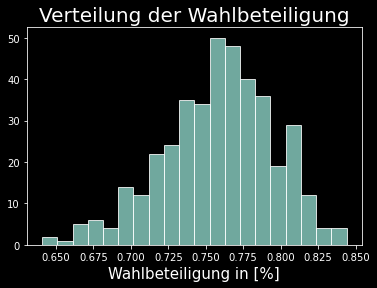

In [32]:
plt.style.use('dark_background')
plt.hist(voting_perc,bins=20,edgecolor='white',alpha=0.8)
plt.title('Verteilung der Wahlbeteiligung',fontsize=20)
plt.xlabel('Wahlbeteiligung in [%]',fontsize=15)

Next, we look at the female to male ratio 

In [33]:
sex_ratio = pd.Series({},mapping_filtered_names.index, dtype=float)
sex_ratio.index.name = 'ID'

for idx in mapping_filtered_names.index:
    male = df_demogr['männlich'].loc[mapping_filtered_names.loc[idx,'df'],:].sum()
    female = df_demogr['weiblich'].loc[mapping_filtered_names.loc[idx,'df'],:].sum()
    #male = df_demogr['männlich'].loc[mapping_filtered_names.loc[idx,'df'],'18 bis unter 20 Jahre':'35 bis unter 40 Jahre'].sum()
    #female = df_demogr['weiblich'].loc[mapping_filtered_names.loc[idx,'df'],'18 bis unter 20 Jahre':'35 bis unter 40 Jahre'].sum()
    sex_ratio[idx] = female/male

Text(0.5, 0, 'Verhältnis Frauen:Männer')

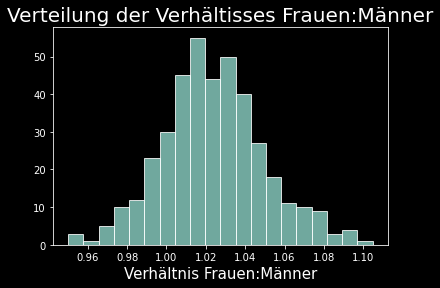

In [34]:
plt.style.use('dark_background')
plt.hist(sex_ratio,bins=20,edgecolor='white',alpha=0.8)

plt.title('Verteilung der Verhältisses Frauen:Männer',fontsize=20)
plt.xlabel('Verhältnis Frauen:Männer',fontsize=15)

We want a scalar metric, that gives us an idea about the demografic distribution of each area. Therefore, we will look at the information entropy $S$ for each area, defined as

$S = -\sum_{i} p_{i} \textrm{log}(p_{i})$

Here, $p_{i}$ is the ratio of $i$th age group to the total population of the area and the index $i$ runs through all age groups and both sexes, under the contraint $\sum_{i} p_{i} = 1$.   

Intuitively, the entropy tells us by how much a distribution deviates from the uniform distribution (where each $p_{i}$ is equal). The lower the value, the more it deviates and hence, the more uneven the population distribution is.

In [35]:
entropy = pd.Series({},mapping_filtered_names.index,dtype=float)
entropy.index.name = 'ID'

for idx in mapping_filtered_names.index:
    norm = df_demogr.loc[mapping_filtered_names.loc[idx,'df'],:].sum()
    pp = df_demogr.loc[mapping_filtered_names.loc[idx,'df'],:]/norm
    entropy[idx] = sum(-pp*np.log(pp))    

Text(0.5, 1.0, 'Verteilung der Informations-Entropie')

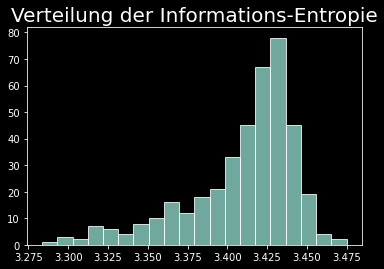

In [36]:
plt.style.use('dark_background')
plt.hist(entropy,bins=20,edgecolor='white',alpha=0.8)
plt.title('Verteilung der Informations-Entropie',fontsize=20)

The same can be done for the demographic data with equal groupings.  

In [37]:
entropy_grp = pd.Series({},mapping_filtered_names.index,dtype=float)
entropy_grp.index.name = 'ID'

for idx in mapping_filtered_names.index:
    norm = df_demogr_grp.loc[mapping_filtered_names.loc[idx,'df'],:].sum()
    pp = df_demogr_grp.loc[mapping_filtered_names.loc[idx,'df'],:]/norm
    entropy_grp[idx] = sum(-pp*np.log(pp)) 

Text(0.5, 1.0, 'Verteilung der Informations-Entropie\n(äquidistante Altersgruppen)')

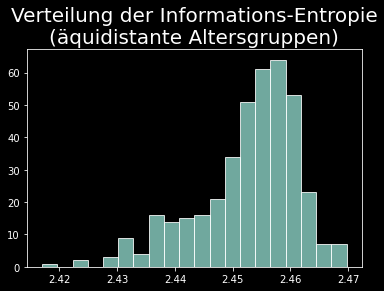

In [38]:
plt.style.use('dark_background')
plt.hist(entropy_grp,bins=20,edgecolor='white',alpha=0.8)
plt.title('Verteilung der Informations-Entropie\n(äquidistante Altersgruppen)',fontsize=20)

Finally, let us also have a look at the voter distribution that the german party AfD got during the last elections.

In [39]:
afd_votes = pd.Series({},mapping_filtered_names.index,dtype=float)
afd_votes.index.name = 'ID'

parties = df_election.columns.get_level_values(0).unique().drop(['Wahlberechtigte','Wähler','Gültige','Ungültige'])

for idx in mapping_filtered_names.index:
    norm = df_election[parties].loc[mapping_filtered_names.loc[idx,'df_election'],:].sum()
    count = df_election[parties].loc[mapping_filtered_names.loc[idx,'df_election'],'AfD'].sum()
    afd_votes[idx] = count/norm 

Text(0.5, 0, 'Anteil der Erst und Zweitstimmen in [%]')

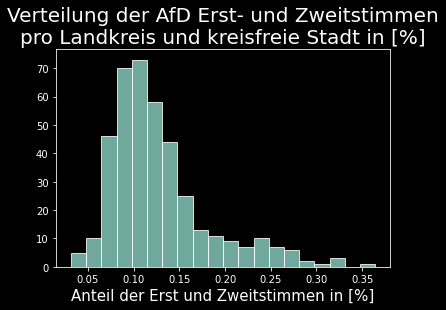

In [40]:
plt.style.use('dark_background')
plt.hist(afd_votes,bins=20,edgecolor='white',alpha=0.8)
plt.title('Verteilung der AfD Erst- und Zweitstimmen\npro Landkreis und kreisfreie Stadt in [%]',fontsize=20)
plt.xlabel('Anteil der Erst und Zweitstimmen in [%]',fontsize=15)

Disrtricts where the AfD got over 30% of total votes:

In [41]:
mapping_filtered_names.loc[afd_votes[afd_votes>=0.3].index,'df']

ID
353                       Mittelsachsen, Landkreis
357                             Bautzen, Landkreis
358                             Görlitz, Landkreis
359                              Meißen, Landkreis
360    Sächsische Schweiz-Osterzgebirge, Landkreis
Name: df, dtype: object

Lets apply some simple statistical analysis to check the dependency structure in our metrics, that we will combine into one dataframe `df_metrics`. 

array([[<AxesSubplot:xlabel='voting_percentage', ylabel='voting_percentage'>,
        <AxesSubplot:xlabel='sex_ratio', ylabel='voting_percentage'>,
        <AxesSubplot:xlabel='entropy', ylabel='voting_percentage'>,
        <AxesSubplot:xlabel='afd_votes', ylabel='voting_percentage'>],
       [<AxesSubplot:xlabel='voting_percentage', ylabel='sex_ratio'>,
        <AxesSubplot:xlabel='sex_ratio', ylabel='sex_ratio'>,
        <AxesSubplot:xlabel='entropy', ylabel='sex_ratio'>,
        <AxesSubplot:xlabel='afd_votes', ylabel='sex_ratio'>],
       [<AxesSubplot:xlabel='voting_percentage', ylabel='entropy'>,
        <AxesSubplot:xlabel='sex_ratio', ylabel='entropy'>,
        <AxesSubplot:xlabel='entropy', ylabel='entropy'>,
        <AxesSubplot:xlabel='afd_votes', ylabel='entropy'>],
       [<AxesSubplot:xlabel='voting_percentage', ylabel='afd_votes'>,
        <AxesSubplot:xlabel='sex_ratio', ylabel='afd_votes'>,
        <AxesSubplot:xlabel='entropy', ylabel='afd_votes'>,
        <AxesSubplo

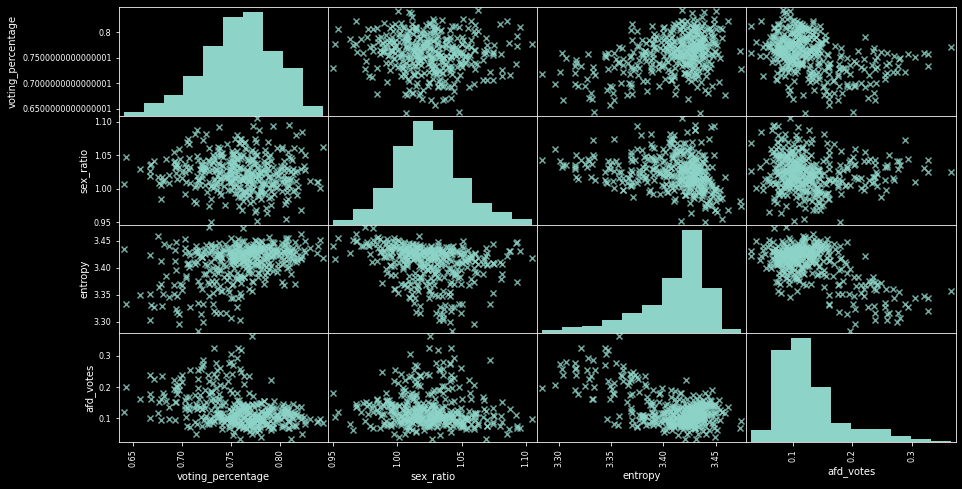

In [42]:
#check for correlations in the above metrics

df_metrics = pd.DataFrame([],index=mapping_filtered_names.index)
df_metrics['voting_percentage'] = voting_perc
df_metrics['sex_ratio'] = sex_ratio
df_metrics['entropy'] = entropy
df_metrics['afd_votes'] = afd_votes

pd.plotting.scatter_matrix(df_metrics, alpha=0.8, edgecolor='white',figsize=(15,8),marker='x')

In [43]:
#save metrcs for later use
df_metrics.to_csv(data_dir + 'metrics.csv',sep=';',decimal=',')

After this first visual examination, lets create a correlation table and look at the significance level (highest significance level is choosen to be 1% and denoted by 3 stars, i.e. ***)

In [44]:
#compute correlations
#statistical significance denoted in asterisks:
rho = df_metrics.corr()
pval = df_metrics.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
rho.round(2).astype(str) + p

,voting_percentage,sex_ratio,entropy,afd_votes
voting_percentage,1.0***,-0.09*,0.4***,-0.38***
sex_ratio,-0.09*,1.0***,-0.26***,-0.08
entropy,0.4***,-0.26***,1.0***,-0.61***
afd_votes,-0.38***,-0.08,-0.61***,1.0***


We see mostly low correlations, however it is apparent that the demographic distributions (in the form of entropy), has the highest correlation with the AfD votes. The sex ratio on the other hand shows low correlation with AfD votes.

We can repeat the analysis, by only considering the districts where the AfD got past a certain threshold, to rule out undesired behavior in the low election vote areas.

array([[<AxesSubplot:xlabel='voting_percentage', ylabel='voting_percentage'>,
        <AxesSubplot:xlabel='sex_ratio', ylabel='voting_percentage'>,
        <AxesSubplot:xlabel='entropy', ylabel='voting_percentage'>,
        <AxesSubplot:xlabel='afd_votes', ylabel='voting_percentage'>],
       [<AxesSubplot:xlabel='voting_percentage', ylabel='sex_ratio'>,
        <AxesSubplot:xlabel='sex_ratio', ylabel='sex_ratio'>,
        <AxesSubplot:xlabel='entropy', ylabel='sex_ratio'>,
        <AxesSubplot:xlabel='afd_votes', ylabel='sex_ratio'>],
       [<AxesSubplot:xlabel='voting_percentage', ylabel='entropy'>,
        <AxesSubplot:xlabel='sex_ratio', ylabel='entropy'>,
        <AxesSubplot:xlabel='entropy', ylabel='entropy'>,
        <AxesSubplot:xlabel='afd_votes', ylabel='entropy'>],
       [<AxesSubplot:xlabel='voting_percentage', ylabel='afd_votes'>,
        <AxesSubplot:xlabel='sex_ratio', ylabel='afd_votes'>,
        <AxesSubplot:xlabel='entropy', ylabel='afd_votes'>,
        <AxesSubplo

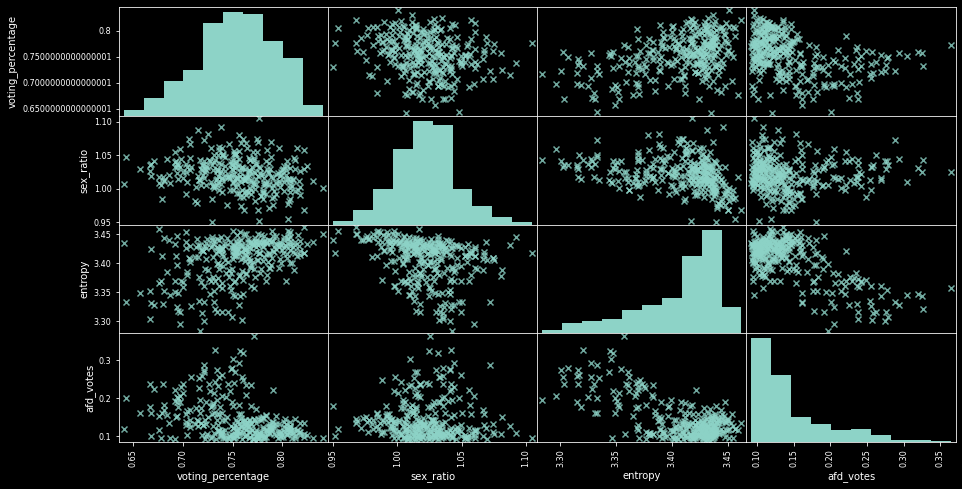

In [45]:
df_metrics_afd = df_metrics.loc[df_metrics['afd_votes']>df_metrics['afd_votes'].quantile(0.25),:]

pd.plotting.scatter_matrix(df_metrics_afd, alpha=0.8, edgecolor='white',figsize=(15,8),marker='x')

In [46]:
#compute correlations
#statistical significance denoted in asterisks:
rho_afd = df_metrics_afd.corr()
pval_afd = df_metrics_afd.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho_afd.shape)
p_afd = pval_afd.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
rho_afd.round(2).astype(str) + p_afd

,voting_percentage,sex_ratio,entropy,afd_votes
voting_percentage,1.0***,-0.19***,0.43***,-0.36***
sex_ratio,-0.19***,1.0***,-0.3***,-0.01
entropy,0.43***,-0.3***,1.0***,-0.68***
afd_votes,-0.36***,-0.01,-0.68***,1.0***


In either case, the sex ratio does not show significant correlation with AfD votes. Lets have a closer look at the correlation matrix for all age and sex groups (including AfD votes).

For this and also for the following discussion, we will create a dataframe `df_demogr_table` out of `df_demogr` with the population for each age group and gender in %. Also, we want to include some additional features for later plotting. We start by creating a multi index out of the age groups and the city names. We add columns for the male and female population, the age groups and the age span (i.e. how many years does each of the age groups span). The last two columns are used for plotting later on.  

In [47]:
#create multi index
ageGrp = pd.Series(['0-2','3-5','6-9','10-14','15-17','18-19','20-24','25-29','30-34','35-39','40-44',
          '45-49','50-54','55-59','60-64','65-74','75+'])
ageGrp.index = df_demogr.loc[df_demogr.index[0],:]['männlich'].index
#age span, i.e. how many years does each of the above age group span
ageSpn = pd.Series([3,3,4,5,3,2,5,5,5,5,5,5,5,5,5,10,15]).values

index = []
for i in product(df_demogr.index,ageGrp):
    index.append(i)

#initialize empty dataframe with multi index    
df_demogr_table = pd.DataFrame([],index=pd.MultiIndex.from_tuples(index))    

#add columns for all values
df_demogr_table['PopMale%'] = 0
df_demogr_table['PopFemale%'] = 0
df_demogr_table['AgeGrpStart'] = 0
df_demogr_table['AgeGrp'] = 0

for i in notebook.tqdm(df_demogr.index):
    
    temp_m = df_demogr.loc[i,'männlich'].copy()
    temp_m.index = ageGrp[df_demogr.loc[i,'männlich'].index]
    
    temp_f = df_demogr.loc[i,'weiblich'].copy()
    temp_f.index = ageGrp[df_demogr.loc[i,'weiblich'].index]
    
    norm = temp_m.sum() + temp_f.sum()
    
    df_demogr_table.loc[i,'PopMale%'] = temp_m.values/norm
    df_demogr_table.loc[i,'PopFemale%'] = temp_f.values/norm
    
    df_demogr_table.loc[i,'AgeGrpStart'] = ageSpn
    df_demogr_table.loc[i,'AgeGrp'] = ageGrp.values

  0%|          | 0/401 [00:00<?, ?it/s]

Out of this dataframe, we will create a new dataframe `demogr_matrix` that has city names as single indices and age groups as single columns. To this we add the metric for our AfD votes. This is the basis for the new correlation matrix.   

In [48]:
demogr_mat_cols = pd.Series(['0-2','3-5','6-9','10-14','15-17','18-19','20-24','25-29','30-34','35-39','40-44',
                             '45-49','50-54','55-59','60-64','65-74','75+'])
demogr_mat_cols = np.append('afd_votes', np.append(demogr_mat_cols.values + '_m%', demogr_mat_cols.values + '_f%'))
demogr_matrix = pd.DataFrame(np.zeros((len(mapping_filtered_names.index),len(demogr_mat_cols))),
                             columns = demogr_mat_cols,
                             index = mapping_filtered_names.index
                            )

for i in notebook.tqdm(mapping_filtered_names.index):
    demogr_matrix.loc[i,'afd_votes'] = afd_votes[i]
    demogr_matrix.loc[i,'0-2_m%':'75+_m%'] = df_demogr_table.loc[mapping_filtered_names.loc[i,'df'],'PopMale%'].values
    demogr_matrix.loc[i,'0-2_f%':'75+_f%'] = df_demogr_table.loc[mapping_filtered_names.loc[i,'df'],'PopFemale%'].values

  0%|          | 0/401 [00:00<?, ?it/s]

Computing all correlations is done as before.

In [49]:
rho_demogr = demogr_matrix.corr()
#rho_demogr = demogr_matrix.loc[demogr_matrix['afd_votes']>demogr_matrix['afd_votes'].quantile(0.25),:].corr()
pval_demogr = demogr_matrix.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho_demogr.shape)
p_demogr = pval_demogr.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
afd_significance = rho_demogr.round(2).astype(str) + p_demogr

Lets look at the groups that have an absolute correlation value of 0.5 or higher with respect to AfD votes.

In [50]:
afd_significance.loc['afd_votes',:][abs(rho_demogr.loc['afd_votes',:])>0.5]

afd_votes      1.0***
18-19_m%     -0.65***
20-24_m%     -0.57***
25-29_m%     -0.51***
18-19_f%     -0.67***
20-24_f%     -0.51***
25-29_f%     -0.53***
60-64_f%      0.51***
65-74_f%      0.56***
75+_f%        0.59***
Name: afd_votes, dtype: object

We see moderate correlation in the above demographic groups (all signifcant on the 1% level). We see negative correlation with the AfD votes for the younger generation (decrease in population) and positive correlation for the older one (increase in population). 
>**NOTE:** The correlation is higher for older females than males by around 0.1 

We repeat the computation for the demography data tables but with equidistant age groups (i.e. all with 15 year intervalls). The resulting dataframe is called `df_demogr_grp_table`.

In [51]:
#lets create the same table but with equidistant age groups (i.e. all with 15 year intervalls)
ageGrp = pd.Series(['0-14','15-29','30-44','45-59','60-74','75+'])
ageGrp.index = df_demogr_grp.loc[df_demogr_grp.index[0],:]['männlich'].index
ageSpn = pd.Series([5,5,5,5,5,5]).values

index = []
for i in product(df_demogr_grp.index,ageGrp):
    index.append(i)
    
df_demogr_grp_table = pd.DataFrame([],index=pd.MultiIndex.from_tuples(index))    

df_demogr_grp_table['PopMale%'] = 0
df_demogr_grp_table['PopFemale%'] = 0
df_demogr_grp_table['AgeGrpStart'] = 0
df_demogr_grp_table['AgeGrp'] = 0

for i in notebook.tqdm(df_demogr_grp.index):
    
    temp_m = df_demogr_grp.loc[i,'männlich'].copy()
    temp_m.index = ageGrp[df_demogr_grp.loc[i,'männlich'].index]
    
    temp_f = df_demogr_grp.loc[i,'weiblich'].copy()
    temp_f.index = ageGrp[df_demogr_grp.loc[i,'weiblich'].index]
    
    norm = temp_m.sum() + temp_f.sum()
    
    df_demogr_grp_table.loc[i,'PopMale%'] = temp_m.values/norm
    df_demogr_grp_table.loc[i,'PopFemale%'] = temp_f.values/norm
    
    df_demogr_grp_table.loc[i,'AgeGrpStart'] = ageSpn
    df_demogr_grp_table.loc[i,'AgeGrp'] = ageGrp.values

  0%|          | 0/401 [00:00<?, ?it/s]

## 4 Visualization: Interactive Maps

The goal of this section is to create interactive maps with different heatmaps representing certain metrics, based on the data from the previous section. In addition we will add popup plots for each area containing the demographic distributions.

Starting with the popup plots, the next function will use either `df_demogr_table` or `df_demogr_grp_table` to create a plot of the population pyramid for a given city with the option to save the resuling figure as a png file.
>**NOTE:** The directories for the files must exist if you want to save them.

In [52]:
def demographic_plot(city, equidistant=False ,save2dir = False):
    plt.style.use('dark_background')
    
    #if eqidistant is selected, select the needed values from the respective dataframe 
    if equidistant:
        pos = df_demogr_grp_table.loc[city]['AgeGrpStart'].cumsum()
        val_m = df_demogr_grp_table.loc[city]['PopMale%']*100
        val_f = df_demogr_grp_table.loc[city]['PopFemale%']*100
        
        agegrpstart = df_demogr_grp_table.loc[city]['AgeGrpStart']
        yticks = df_demogr_grp_table.loc['Flensburg, kreisfreie Stadt',:]['AgeGrp']
    else:
        pos = df_demogr_table.loc[city]['AgeGrpStart'].cumsum()
        val_m = df_demogr_table.loc[city]['PopMale%']*100
        val_f = df_demogr_table.loc[city]['PopFemale%']*100
        
        agegrpstart = df_demogr_table.loc[city]['AgeGrpStart']
        yticks = df_demogr_table.loc['Flensburg, kreisfreie Stadt',:]['AgeGrp']

    fig, axes = plt.subplots(figsize=(10,9), ncols=2, sharey=True)
    axes[0].barh(pos, val_m, agegrpstart,
                 align='center', color='cornflowerblue', zorder=10, edgecolor='white',alpha=0.95)
    axes[0].set(title='% Male')
    axes[1].barh(pos, val_f, agegrpstart,
                 align='center', color='orchid', zorder=10, edgecolor='white',alpha=0.95)
    axes[1].set(title='% Female')

    axes[0].invert_xaxis()
    axes[0].set(yticks=pos, yticklabels=yticks)
    axes[0].yaxis.tick_right()

    axes[0].set_xlim(1.05*max(val_m.max(),val_f.max()),0)
    axes[1].set_xlim(0,1.05*max(val_m.max(),val_f.max()))

    plt.rc('font', size=12) #controls default text size

    for ax in axes.flat:
        ax.margins(0.03)
        ax.grid(True)
    
    plt.suptitle(city.split(', ')[0],fontsize=25)
    
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.205)
    if save2dir:
        #do a string replace for entries like Australia/New Zeeland, which treat the / as a new subdirectory
        if equidistant:
            plt.savefig(result_dir + 'demographic_grp/{}_demographic.png'.format(city), dpi=75)
        else:
            plt.savefig(result_dir + 'demographic/{}_demographic.png'.format(city), dpi=75)
    plt.close(fig)
    
    return(fig)

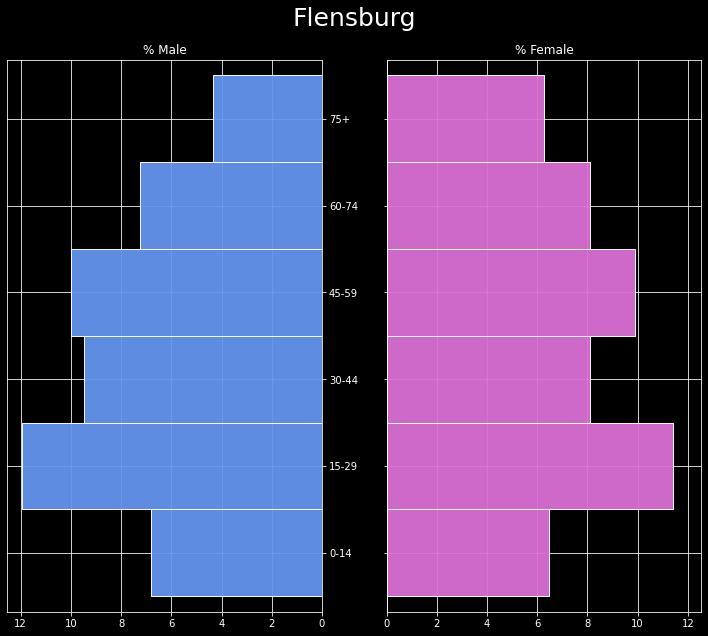

In [53]:
#as an example:
fig = demographic_plot('Flensburg, kreisfreie Stadt',equidistant=True)
fig

Run the plotting function for all cities and both dataframes.

In [73]:
for city in notebook.tqdm(df_names):
    demographic_plot(city,equidistant=False,save2dir=True)
    demographic_plot(city,equidistant=True,save2dir=True)

<ipython-input-73-39ef0db9ca5f>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for city in tqdm_notebook(df_names):


  0%|          | 0/401 [00:00<?, ?it/s]

The following function creates the interactive maps. You have the option to:
- specify the metric that you want to have displayed as a heatmap
- the caption of the color bar
- which demographic data to use in the popup window
- the name of the resulting htm file.

>For an explanation of the code below, check out section 4.4 of my script on [Introduction to Visualizations with matplotlib and folium](https://github.com/pmurati/WorkshopVisualization).

In [54]:
def interactive_map_plot(metric,caption,equidistant,save_as):
    
    cols_list = []
    cols = plt.cm.get_cmap('inferno', 10).colors
    for cc in cols:
        cols_list.append(list(cc))

    #specify a continuous color gradient
    color_grad = cmp.LinearColormap(
        cols_list,
        #['black','white'],
        #avoid skewing the coloring and define the gradient only up to the 95% quantile
        vmin=metric.min(), vmax=metric.max(),
        caption=caption
    )

    germany = folium.Map(location=(48.3984100, 9.9915500),
                                zoom_start=7,tiles='CartoDBPositron')
    heatmaps = folium.FeatureGroup(name='Heatmap').add_to(germany)
    städte_kreise = folium.FeatureGroup(name='Städte Namen').add_to(germany)
    
    #add the heatmap
    folium.GeoJson(
        gj_lk_f2,
        style_function=lambda feature: {
            'fillColor': color_grad(metric[feature['id']]),
            'color': 'white',
            'weight': 0.9,
            'fillOpacity': 0.7
        }
    ).add_to(heatmaps)
    color_grad.add_to(germany)

    for i in range(len(gj_lk_f2['features'])):
        coord = gj_lk_f2['features'][i]['geometry']['coordinates'][0]
        p = [shape(gj_lk_f2['features'][i]['geometry']).centroid.y,
             shape(gj_lk_f2['features'][i]['geometry']).centroid.x]    

        p_name = gj_lk_f2['features'][i]['properties']['name']

        #include graphic
        city = mapping_filtered_names.loc[
        mapping_filtered_names['gj']==gj_lk_f2['features'][i]['properties']['name'],'df']

        #taken from https://stackoverflow.com/questions/58227034/png-image-not-being-displayed-on-folium-map
        if equidistant:
            path = result_dir + 'demographic_grp/{}_demographic.png'.format(list(city)[0])
        else:
            path = result_dir + 'demographic/{}_demographic.png'.format(list(city)[0])
        encoded = base64.b64encode(open(path, 'rb').read()).decode()

        resolution, width, height = 75, 10, 9

        html = '<img src="data:image/png;base64,{}">'.format
        iframe = IFrame(html(encoded), width=(width*resolution)+20, height=(height*resolution)+20)
        popup = folium.Popup(iframe, max_width=2650)

        folium.Marker(p, icon=DivIcon(
            icon_size=(150,36),
            icon_anchor=(7,20),
           #html='<div style="font-size: 10pt; color : black">{}</div>'.format(p_name)
        ),
                     popup = popup
                     ).add_to(germany)

        #add filter to show/hide country name
        folium.Marker(p, icon=DivIcon(
            icon_size=(150,36),
            icon_anchor=(7,20),
            html='<div style="font-size: 10pt; color : white">{}</div>'.format(p_name)),
                     ).add_to(städte_kreise)

        germany.add_child(folium.CircleMarker(p, radius=0.5,color='white',weight=0.7))

    folium.LayerControl().add_to(germany)

    #export the final map as an html page 
    germany.save(result_dir + save_as + '.html')
    

Creating the different html files:

In [60]:
interactive_map_plot(metric = voting_perc,
                     caption = 'Wahlbeteiligung in [%]',
                     equidistant = False, 
                     save_as = 'Wahlbeteiligung_DE')

In [64]:
interactive_map_plot(metric = sex_ratio,
                     caption = 'Verhältnis von Frauen zu Männern',
                     equidistant = False,
                     save_as = 'Geschlechterverteilung_DE')

In [62]:
interactive_map_plot(metric = entropy,
                     caption = '(Informationstheoretische) Entropien',
                     equidistant = False,
                     save_as = 'Entropie_DE'
                    )

In [63]:
interactive_map_plot(metric = entropy_grp,
                     caption = '(Informationstheoretische) Entropien',
                     equidistant = True,
                     save_as = 'Entropie_grp_DE'
                    )

In [55]:
interactive_map_plot(metric = 100*afd_votes,
                     caption = 'Anteil der Erst- und Zweitstimmen für die AfD in [%]',
                     equidistant = False,
                     save_as = 'AfD_Stimmen_DE'
                    )
interactive_map_plot(metric = 100*afd_votes,
                     caption = 'Anteil der Erst- und Zweitstimmen für die AfD in [%]',
                     equidistant = True,
                     save_as = 'AfD_Stimmen_DE_equidistant'
                    )

To conclude this script, create a table of different features for the upcoming modeling script. The table contains:
- men and women per age group in [%]
- entropy measure based on above propabilites
- population per city in [%] (wrt. to whole population of Germany)
- population density
- ratio of men to women (per age group)

In [55]:
df_feature_table = pd.DataFrame({},index=mapping_filtered_names.index)
df_feature_table.index.name = 'ID'

df_feature_table['entropy'] = 0
df_feature_table['pop%'] = 0
df_feature_table['pop_density'] = 0

col_agegrp = df_demogr_table.index.get_level_values(1).unique()
col_m = list(col_agegrp + '_m%')
col_f = list(col_agegrp + '_f%')
col_ratio = list(col_agegrp + '_ratio')

for idx in range(len(col_agegrp)):
    df_feature_table[col_m[idx]] = 0
    df_feature_table[col_f[idx]] = 0
    df_feature_table[col_ratio[idx]] = 0

total_pop = 0
for idx in notebook.tqdm(mapping_filtered_names.index):
    norm = df_demogr.loc[mapping_filtered_names.loc[idx,'df'],:].sum()
    total_pop += norm
    
    pp = df_demogr.loc[mapping_filtered_names.loc[idx,'df'],:]/norm
    df_feature_table.loc[idx,'entropy'] = sum(-pp*np.log(pp))  

    df_feature_table.loc[idx,'pop%'] = norm
    
    df_feature_table.loc[idx,'pop_density'] = norm/shape(gj_lk_f2['features'][idx]['geometry']).area
    
    for idx_ag in range(len(col_agegrp)):
        pop_m_perc = df_demogr_table.loc[mapping_filtered_names.loc[idx,'df']].loc[
            col_agegrp[idx_ag],'PopMale%']
        pop_f_perc = df_demogr_table.loc[mapping_filtered_names.loc[idx,'df']].loc[
            col_agegrp[idx_ag],'PopFemale%']
        
        df_feature_table.loc[idx,col_m[idx_ag]] = pop_m_perc
        df_feature_table.loc[idx,col_f[idx_ag]] = pop_f_perc
        df_feature_table.loc[idx,col_ratio[idx_ag]] = pop_m_perc/pop_f_perc
        
    
#scale entropy    
entr_min = df_feature_table['entropy'].min()
entr_max = df_feature_table['entropy'].max()
df_feature_table['entropy'] = (df_feature_table['entropy']-entr_min)/(entr_max-entr_min)    

#scale population density
pop_dens_min = df_feature_table['pop_density'].min()
pop_dens_max = df_feature_table['pop_density'].max()
df_feature_table['pop_density'] = (df_feature_table['pop_density']-pop_dens_min)/(pop_dens_max-pop_dens_min)  

#% in total population per city
df_feature_table['pop%'] /= total_pop 

  0%|          | 0/401 [00:00<?, ?it/s]

In [56]:
df_feature_table.to_csv(data_dir+'feature_table.csv',sep=';',decimal=',')

Also, save election results

In [105]:
df_election.to_csv(data_dir + 'election_table.csv',sep=';',decimal=',')